# Racial disparities in police stops in Boston
 
Boston Mayor Marty Walsh [declared racism a public health crisis in June 2020](https://www.npr.org/sections/live-updates-protests-for-racial-justice/2020/06/12/876327158/boston-mayor-declares-racism-a-public-health-crisis), committing to reallocating $3 million from the city's police department to public health accounts. Racism and discrimination in Boston is nothing new. 

Black drivers were more likely to be stopped by the Boston Police officers, [according to data](https://www.wgbh.org/news/local-news/2020/06/12/black-people-made-up-70-percent-of-boston-police-stops-department-data-show) collected by the Field Interrogation and Observation (FIO) program. The FIO records include interactions between the BPD and stopped drivers from 2011 to 2019. Through analyzing the records, we can get a sense of whether racial bias exists in stop decisions.

Data sources:
- [BPD FIO data](https://data.boston.gov/dataset/boston-police-department-fio) (2011 - 2019, I'm using data between 2015 and 2019)

Questions I want to answer:
- Are there any biases in stop decisions? If yes, why(violation types)?
- Bias in post-stop decisions: which stopped people were frisked?
- Any significant changes after the legalization of recreational marijuana?
- Do field contacts involved in certain officers lead to higher possibility of getting frisked/searched?
- Different patterns in different neighborhoods?

(Some of the following codes were referenced from the data analysis done by [@jacoblurye](https://github.com/jacoblurye/bpd-fio-data/blob/master/process_bpd_fio_data.ipynb). Thanks to him, my data cleaning process was less painful.)

In [1]:
# import packages
import pandas as pd
import re
import datetime
import missingno as msno
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [3]:
# load in datasets from 2015 to 2019
# there are two kinds of datasets - 
# field contacts data list each contact between BPD and one or more individuals
# field contacts name data list each individual involved in these contacts

ind_path191 = 'data/bpd/rms_fieldcontacts_name_for_public_2019.csv'
pol_path191 = 'data/bpd/rms_fieldcontacts_for_public_2019.csv'
ind_path192 = 'data/bpd/mark43_fieldcontacts_name_for_public_2019.csv'
pol_path192 = 'data/bpd/mark43_fieldcontacts_for_public_20192.csv'
ind_path18 = 'data/bpd/rms_fieldcontacts_name_for_public_2018_202003111443.csv'
pol_path18 = 'data/bpd/rms_fieldcontacts_2018.csv'
ind_path17 = 'data/bpd/rms_fieldcontacts_name_for_public_2017_202003111442.csv'
pol_path17 = 'data/bpd/rms_fieldcontacts_for_public_2017_202003111424.csv'
ind_path16 = 'data/bpd/fieldcontactnameforpublic2016.csv'
pol_path16 = 'data/bpd/fieldcontactforpublic2016.csv'
ind_path15 = 'data/bpd/fieldcontactnameforpublic2015.csv'
pol_path15 = 'data/bpd/fieldcontactforpublic2015.csv'
# pathB15 = 'data/bpd/boston-police-department-fio.csv'

ind_files = [ind_path191, ind_path192, ind_path18, ind_path17, ind_path16, ind_path15]
pol_files = [pol_path191, pol_path192, pol_path18, pol_path17, pol_path16, pol_path15]

def read_concat_csv(files):
    li = []

    for filename in files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    concated = pd.concat(li, axis=0, ignore_index=True)

    return concated


indvsl = read_concat_csv(ind_files)
plc = read_concat_csv(pol_files)

#### !!!IMPORTANT MSG from the BPD!!!

"While these two tables align on the field contact number (fc_num) column, it is not methodologically correct to join the two datasets for the purpose of generating aggregate statistics on columns from the FieldContact table. Doing so would lead to incorrect estimates stemming from contacts with multiple individuals. As noted in the Data Key (New RMS) file, several of the columns in the FieldContact table apply to the contact as a whole, but may not necessarily apply to each individual involved in the contact." These include:

- frisked
- searchperson
- summonsissued
- circumstances
- basis
- contact_reason


# 1.Data Cleaning

### Deal with the frisk/search columns in field contact (fc) dataset (a.k.a plc)

Something worth noting here is that the "frisked" and "searchperson" in the field contacts data, which was generated from the "New RMS" system, indicate at least one indivisual was frisked or searched in the incident. However, the fc data generated from MARK43 system (between SEPT 29 and DEC 31 2019) doesn't contain those two columns. The good news is that the fc name (a.k.a. indvsl) data from MARK43 documented the frisk/search value at an indivisual level, indicating whether the indivisual was frisked or searched during a field contact. 

In [4]:
# columns included in plc data
plc.columns

Index(['fc_num', 'contact_date', 'contact_officer', 'contact_officer_name',
       'supervisor', 'supervisor_name', 'street', 'city', 'state', 'zip',
       'frisked', 'searchperson', 'searchvehicle', 'summonsissued',
       'stop_duration', 'circumstance', 'basis', 'vehicle_year',
       'vehicle_state', 'vehicle_make', 'vehicle_model', 'vehicle_color',
       'vehicle_style', 'vehicle_type', 'contact_reason', 'key_situations',
       'narrative', 'weather', 'streetaddr'],
      dtype='object')

In [5]:
# number of rows and columns
plc.shape

(44105, 29)

In [6]:
# 35 records in the "contacts" dataset contain duplicate values in fc_num column, which should be an unique id. 
plc[plc.duplicated(subset=["fc_num"], keep=False)]

,fc_num,contact_date,contact_officer,contact_officer_name,supervisor,supervisor_name,street,city,state,zip,...,vehicle_make,vehicle_model,vehicle_color,vehicle_style,vehicle_type,contact_reason,key_situations,narrative,weather,streetaddr
6639,FC19000069,2019-10-01 0:00:00,110128,"DASILVA, MOSES-JOSE",11586.0,CHRISTOPHER CARROLL,E SPRINGFIELD ST,BOSTON,MA,2118,...,NaN,NaN,NaN,NaN,NaN,NaN,"Homeless, Drugs",Officer responded to a call for for a two male...,Cloudy/Partly Cloudy,NaN
6640,FC19000069,2019-10-01 0:00:00,110128,"DASILVA, MOSES-JOSE",11586.0,CHRISTOPHER CARROLL,E SPRINGFIELD ST,BOSTON,MA,2118,...,NaN,NaN,NaN,NaN,NaN,NaN,"Homeless, Drugs",Officer responded to a call for for a two male...,Cloudy/Partly Cloudy,NaN
6653,FC19000191,2019-10-04 21:10:00,126574,"O'DWYER, MICHAEL",75661.0,JUANA HERNANDEZ,NaN,ROXBURY,MA,2119,...,NaN,Elantra,BLUE,"4 Door, Sedan",Passenger Car/ Automobile,NaN,Gang,orchard park associates XXX andXXX along with ...,Clear (Night),NaN
6654,FC19000191,2019-10-04 21:10:00,126574,"O'DWYER, MICHAEL",75661.0,JUANA HERNANDEZ,NaN,ROXBURY,MA,2119,...,NaN,Elantra,BLUE,"4 Door, Sedan",Passenger Car/ Automobile,NaN,Gang,orchard park associates XXX andXXX along with ...,Clear (Night),NaN
6667,FC19000323,2019-10-08 9:12:00,12020,"HARLOW, DANIEL",11586.0,CHRISTOPHER CARROLL,MELNEA CASS BLVD,BOSTON,MA,2119,...,NaN,NaN,NaN,NaN,NaN,NaN,"Homeless, Drugs","At about 0918 on October 8, 2019 Officers resp...",Cloudy/Partly Cloudy,NaN
6669,FC19000323,2019-10-08 9:12:00,12020,"HARLOW, DANIEL",11586.0,CHRISTOPHER CARROLL,MELNEA CASS BLVD,BOSTON,MA,2119,...,NaN,NaN,NaN,NaN,NaN,NaN,"Homeless, Drugs","At about 0918 on October 8, 2019 Officers resp...",Cloudy/Partly Cloudy,NaN
6800,FC19001601,2019-12-04 23:01:00,116222,"RAMOS, ANTOINE",10163.0,THOMAS PRATT,NaN,BOSTON,MA,2120,...,NaN,NaN,NaN,NaN,NaN,NaN,Gang,Youth Violence Strike Force Firearms Invest.\n...,Clear (Night),NaN
6801,FC19001601,2019-12-04 23:01:00,116222,"RAMOS, ANTOINE",10163.0,THOMAS PRATT,NaN,BOSTON,MA,2120,...,NaN,NaN,NaN,NaN,NaN,NaN,Gang,Youth Violence Strike Force Firearms Invest.\n...,Clear (Night),NaN
6802,FC19001601,2019-12-04 23:01:00,116222,"RAMOS, ANTOINE",10163.0,THOMAS PRATT,NaN,BOSTON,MA,2120,...,NaN,NaN,NaN,NaN,NaN,NaN,Gang,Youth Violence Strike Force Firearms Invest.\n...,Clear (Night),NaN
6899,FC19000558,2019-10-15 16:40:00,99776,"LEVICHEV, VLADIMIR",81410.0,MATTHEW RYAN,NaN,BOSTON,MA,2122,...,NaN,Passat,Gray,"4 Door, Sedan",Passenger Car/ Automobile,NaN,NaN,OFFICER OBSERVED ABOVE VEHICLE OPERATED BY XXX...,Cloudy/Partly Cloudy,NaN


In [8]:
# I kept the last record only. 
plc = plc.drop_duplicates(subset=["fc_num"], keep="last")

In [9]:
# lowercase all columns instead of fc_num
fcnum1 = plc["fc_num"]
plc = plc.applymap(lambda x: x.lower() if isinstance(x, str) else x)
plc["fc_num"] = fcnum1

fcnum2 = indvsl["fc_num"]
indvsl = indvsl.applymap(lambda x: x.lower() if isinstance(x, str) else x)
indvsl["fc_num"] = fcnum2


In [10]:
# combine "frisked" and "searchperson" column into one, "frisked_or_searched_involved"
# remember: data generated from mark43 system will have a nan value because it doesn't contain this column
combine_method = (
        lambda row: "y"
        if row.frisked == "Yy" or row.searchperson == "y"
        else np.nan
    )

In [11]:
combined_plc = plc[["frisked", "searchperson"]].apply(
        combine_method, axis=1)

In [13]:
plc["person_involved_in_frisked_or_searched"] = combined_plc
plc = plc.drop(columns=["frisked", "searchperson"]).reset_index(drop=True)

### Deal with the frisk/search columns in fc name dataset (a.k.a. indvsl)

In [300]:
indvsl.columns

Index(['recnum', 'fc_num', 'contact_date', 'sex', 'race', 'age', 'build',
       'hair_style', 'complexion', 'ethnicity', 'otherclothing', 'skin_tone',
       'deceased', 'license_state', 'license_type', 'frisk/search'],
      dtype='object')

In [14]:
# To disambuate the frisk/search column from person_involved_in_frisked_or_searched in plc dataset,
# I rename it "frisk/search"
indvsl = indvsl.rename(columns={"frisk/search": "person_frisked_or_searched"})

In [15]:
# There will be lots of NaN values since only datasets generated from mark43 system have the "frisk/search" column
indvsl.person_frisked_or_searched.value_counts(dropna=False)

NaN    67742
0.0     1755
1.0     1040
Name: person_frisked_or_searched, dtype: int64

In [16]:
indvsl.person_frisked_or_searched = indvsl.person_frisked_or_searched.apply(lambda x: str(x))

In [17]:
# convert the value from 0 and 1 to n and y
indvsl.person_frisked_or_searched = indvsl.person_frisked_or_searched.replace({"0.0":"n", "1.0":"y"})

### Infer whether a filed contact involved a search/frisk conduct from indvsl dataset

In [18]:
''' 
Although the fc data in mark43 system doesn't provide frisked/searched info,
we can infer whether a field contact involved frisked/searched based on
the fc name data - whether the person invovled in the field contact were frisked or searched.
'''
plc_with_no_fs = plc.person_involved_in_frisked_or_searched.isnull()
indvsl_involved_fs = indvsl.groupby("fc_num").apply(
    lambda x: "y"
    if (x.person_frisked_or_searched == "y").any()
    else "n"
    if (x.person_frisked_or_searched == "n").all()
    else np.nan
    )

In [19]:
plc.loc[plc_with_no_fs, "person_involved_in_frisked_or_searched"] = plc[
    plc_with_no_fs
].apply(lambda x: indvsl_involved_fs.loc[x.fc_num], axis=1)

### Datetime object

In [20]:
plc = plc.reset_index(drop=True)
indvsl = indvsl.reset_index(drop=True)

In [21]:
# one weird record should be dropped: 217-04-17 12:30:00
weird_date = "0217-04-17 12:30:00.0000000"
plc = plc[plc.contact_date != weird_date]
indvsl = indvsl[indvsl.contact_date != weird_date]

In [22]:
plc.contact_date = pd.to_datetime(plc.contact_date)
indvsl.contact_date = pd.to_datetime(indvsl.contact_date)

In [23]:
# delete data records before 2015
wrong_year = plc.contact_date.dt.year.astype(int) < 2015 #Again, create a true/false series
plc.loc[wrong_year, "contact_date"] = plc.contact_date[wrong_year] + pd.offsets.DateOffset(year=2015)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:692: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


### Clean vehicle info

In [24]:
plc.head(1)

,fc_num,contact_date,contact_officer,contact_officer_name,supervisor,supervisor_name,street,city,state,zip,...,vehicle_model,vehicle_color,vehicle_style,vehicle_type,contact_reason,key_situations,narrative,weather,streetaddr,person_involved_in_frisked_or_searched
0,F190041435,2019-01-01,148310,"verderico,james",11586.0,"carroll, christopher",NaN,bstn,ma,02118,...,NaN,NaN,NaN,NaN,interaction (massachusetts ave/albany street) ...,NaN,NaN,NaN,NaN,NaN


In [25]:
plc.vehicle_type.unique()

array([nan, 'sedan', 'other', 'compact', 'suv or utility van',
       'station wagon', 'school bus', 'truck', 'bus/passenger van',
       'motorcycle or scooter', 'convertible',
       'passenger car/ automobile', 'cargo van',
       'suv (sport utility vehicle)', 'passenger van', 'pickup truck',
       'scooter', 'other vehicle', 'motorhome', 'construction vehicle'],
      dtype=object)

In [26]:
plc.vehicle_type = plc.vehicle_type.replace({
    "scooter": 'motorcycle or scooter',
    'suv (sport utility vehicle)': 'suv or utility van',
    'cargo van': 'suv or utility van',
    'passenger van': 'bus or passenger van',
    'bus/passenger van': 'bus or passenger van',
    'passenger car/ automobile':'passenger car'
    
})
                                        

In [27]:
plc.vehicle_color.unique()

array([nan, 'black ', 'gray', 'red', 'green ', 'blue', 'lt. blue',
       'white', 'silver', 'brown', 'tan ', 'orange', 'yellow', 'maroon ',
       'lt. green ', 'purple', 'gold', 'cream ', 'bla', 'black', 'green',
       'maroon', 'gra', 'tan', 'gre', 'light green', 'dark blue',
       'dark green', 'pink '], dtype=object)

In [28]:
plc.vehicle_color = plc.vehicle_color.str.rstrip().replace({
    "lt. blue": "light blue",
    "lt. green": "light green",
    "bla": "black",
    "gra": "gray",
    "gre": "grean"
})
            

In [29]:
plc.vehicle_year.value_counts(dropna=False)

NaN       28981
2015.0     1052
2004.0      983
2005.0      959
2008.0      943
          ...  
1981.0        1
1195.0        1
115.0         1
1971.0        1
1977.0        1
Name: vehicle_year, Length: 69, dtype: int64

In [30]:
def fix_year(col):
    if np.isnan(col):
        return col
    if col >= 1900:
        return col
    if (col > 99):
        return np.nan
    if col < 10:
        return f"200{col}"
    if col < 21:
        return f"20{col}"
    else:
        return f"19{col}"        

In [31]:
plc.vehicle_year = plc.vehicle_year.apply(fix_year)

### Combine contact reasons in new RMS and narrative in mark43

In [32]:
missing_contact_reason = plc.contact_reason.isnull()
plc.loc[missing_contact_reason, "contact_reason"] = plc[missing_contact_reason]["narrative"]
plc = plc.drop(columns=["narrative"]).reset_index(drop=True)

### Clean up city columns

In [33]:
plc.city.unique()

array(['bstn', 'boston', nan, 'roslindlae', 'roxbury', 'mattapan',
       'dorchester', 'btsn', 'allston', 'jamaica plain', 'east boston',
       'charlestown', 'south boston', 'revere', 'brighton', 'bsnt',
       'bstna', 'bston', 'palm springs', 'brookline', 'hyde park',
       'jamaiaca plain', 'roslindale', 'west roxbury', 'everett',
       'worcester', 's. boston', 'sommerville', 'milton', 'pembroke',
       'holbrook', 'jamaicia plain', 's.boston', 'dor.', 'e boston',
       'e.boston', 's boston', 'bostob', 'brockton', 'weymouth',
       'dorchest', 'sbos', 'jp', 'chelsea', 'mission hill', 'charlestwon',
       'jamacia plain', 'rox', 'robury', 'so boston', 'so. boston',
       'dorcchester', 'chaarlestown', 'east bos', 'chalrestown',
       'east bostn', 'dor', 'unkown', 'mt', 'andover', 'quincy',
       'dorchster', 'south end', 'dedham', 'bst', 's bstn', 'dorchesterr',
       'canton', 'south  boston', 'jamaiica plain', 'roxbury ma',
       'e. boston', 'jamaica', '307', 'ddo

In [34]:
BOSTON = "boston"
SOUTHIE = "south boston"
DORCHESTER = "dorchester"
CHARLESTOWN = "charlestown"
JP = "jamaica plain"
EASTIE = "east boston"
MATTAPAN = "mattapan"
ROXBURY = "roxbury"
HYDEPARK = "hyde park"

plc.city = plc.city.replace(
        {
            "bstn": BOSTON,
            "so.boston": SOUTHIE,
            "dorcchester": DORCHESTER,
            "chaarlestown": CHARLESTOWN,
            "jp": JP,
            "east bos": EASTIE,
            "chalrestown": CHARLESTOWN,
            "east bostn": EASTIE,
            "dor": DORCHESTER,
            "mt": MATTAPAN,
            "s boston": SOUTHIE,
            "dorchster": DORCHESTER,
            "bst": BOSTON,
            "s bstn": SOUTHIE,
            "dorchesterr": DORCHESTER,
            "jamaiica plain": JP,
            "roxbury ma": ROXBURY,
            "so boston": SOUTHIE,
            "e. boston": EASTIE,
            "jamaica": JP,
            "ddorchester": DORCHESTER,
            "mattpan": MATTAPAN,
            "jamaicia": JP,
            "s. boston": SOUTHIE,
            "hp": HYDEPARK,
            "dorchest": DORCHESTER,
            "sbos": SOUTHIE,
            "rox": ROXBURY,
            "charlestwon": CHARLESTOWN,
            "jamacia plain": JP,
            "robury": ROXBURY,
            "btsn": BOSTON,
            "sommerville": "somerville",
            "jamaicia plain": JP,
            "s.boston": SOUTHIE,
            "dor.": DORCHESTER,
            "e boston": EASTIE,
            "e.boston": EASTIE,
            "bostob": BOSTON,
            "roslindlae": "ROSLINDALE",
            "bsnt": BOSTON,
            "bstna": BOSTON,
            "bston": BOSTON,
            "jamaiaca plain": JP,
            "so. boston": SOUTHIE,
            "unkown": "unknown",
        })
                           

### Clean up age

In [48]:
indvsl.age.describe()

count    68815.000000
mean        28.651864
std         10.305400
min          1.000000
25%         21.000000
50%         26.000000
75%         33.000000
max         93.000000
Name: age, dtype: float64

In [36]:
indvsl.age = indvsl.age.apply(
    lambda x:
        x if (x > 0) & (x < 100)
        else np.nan
    )

### Merge skin tone column in mark34 with complexion column in new rms

In [37]:
missing_complexion = indvsl.complexion.isnull()
indvsl.loc[missing_complexion, "complexion"] = indvsl[missing_complexion]["skin_tone"]
indvsl = indvsl.drop(columns="skin_tone").reset_index(drop=True)

### Reconcile race

In [38]:
indvsl.race = indvsl.race.replace(
        {"american indian or alaskan native": "native american / alaskan native"}
    )

### Correct state name

In [39]:
plc.state = plc.state.replace({"MX": "MA"})

### Reconcile stop duration 

In [41]:
plc.stop_duration.unique()

array(['five to ten minutes', 'ten to fifteen minutes',
       'less than five minutes', 'thirty to forty-five minutes',
       'fifteen to twenty minutes', nan, 'twenty-five to thirty minutes',
       'forty-five to sixty minutes', 'twenty to twenty-five minutes',
       'longer than two hours', 'one to two hours', 60.0, 0.0, 3.0, 14.0,
       740.0, 5.0, 41.0, 10.0, 44.0, 15.0, 39.0, 31.0, 29.0, 21.0, 20.0,
       28.0, 8.0, 40.0, 6.0, 25.0, 17.0, 46.0, 149.0, 23.0, 120.0, 7.0,
       13.0, 18.0, 82.0, 2.0, 26.0, 9.0, 195.0, 32.0, 1.0, 144.0, 16.0,
       30.0, 67745.0, 11.0, 48.0, 49.0, 55.0, 52.0, 19.0, 820.0, 107.0,
       105.0, 4.0, 24.0, 1505.0, 200.0, 990.0, 45.0, 80.0, 1440.0, 43.0,
       1035.0, 38.0, 58.0, 129.0, 11530.0, 47.0, 67578.0, 33.0, 68.0,
       65.0, 131.0, 90.0, 595.0, 674.0, 285.0], dtype=object)

In [42]:
def bucket_stop_duration(d):
        try:
            d = int(d)
        except:
            return d

        if d > 1000:
            return np.nan
        if d < 5:
            return "less than five minutes"
        if d < 10:
            return "five to ten minutes"
        if d < 15:
            return "ten to fifteen minutes"
        if d < 20:
            return "fifteen to twenty minutes"
        if d < 25:
            return "twenty to twenty-five minutes"
        if d < 30:
            return "twenty-five to thirty minutes"
        if d < 45:
            return "thirty to forty-five minutes"
        if d < 60:
            return "forty-five to sixty minutes"
        if d < 120:
            return "one to two hours"
        return "longer than two hours"

plc.stop_duration = plc.stop_duration.apply(bucket_stop_duration)

### Add a year column for future use

In [43]:
# add year column
plc["year"] = plc.contact_date.dt.year.astype(str)

### Reconcile NaN values

In [44]:
replacements = {"": np.nan, "null": np.nan, "none": np.nan}
plc = plc.replace(replacements)
indvsl = indvsl.replace(replacements)

### Calculate number of indivisals involved in a field contact

In [49]:
num_of_indvsl = indvsl.groupby(["fc_num"]).count()["contact_date"]
plc["num_of_stopped_people"] = plc["fc_num"].apply(lambda x: num_of_indvsl[x])

### FINALLY, save the files

In [45]:
plc.to_csv("cleaned_fc_data_2015_2019.csv")
indvsl.to_csv("cleaned_fc_name_data_2015_2019.csv")

In [46]:
plc.shape

(44085, 28)

In [47]:
indvsl.shape

(70536, 15)

# Now, let's merge the two datasets

In [50]:
df_o = indvsl.merge(plc, left_on = 'fc_num', right_on = 'fc_num')

In [51]:
print("We have "+str(df_o.shape[0])+" people who were stopped by the police between 2015 and 2019")

We have 70480 people who were stopped by the police between 2015 and 2019


In [52]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70480 entries, 0 to 70479
Data columns (total 43 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   recnum                                  67224 non-null  float64       
 1   fc_num                                  70480 non-null  object        
 2   contact_date_x                          70480 non-null  datetime64[ns]
 3   sex                                     70123 non-null  object        
 4   race                                    70079 non-null  object        
 5   age                                     68762 non-null  float64       
 6   build                                   52877 non-null  object        
 7   hair_style                              21438 non-null  object        
 8   complexion                              49005 non-null  object        
 9   ethnicity                               48502 non-

In [53]:
df_o.shape

(70480, 43)

In [54]:
df = df_o.copy()

# Missing Values

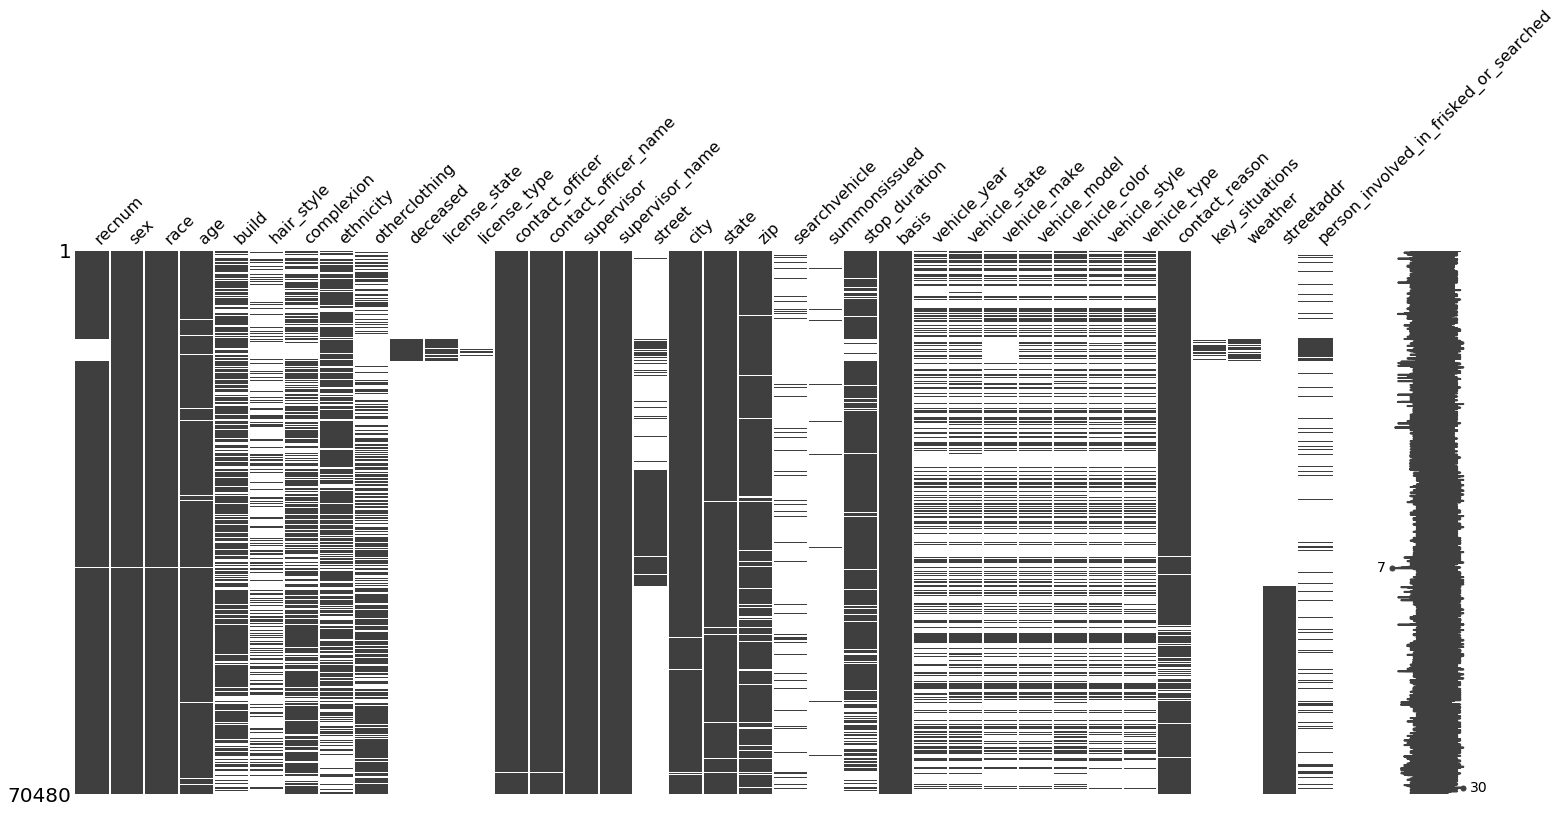

In [55]:
missingdata_df = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missingdata_df])

Based on the above missing value analysis, we can see that some columns are irrelevant or not useful to our analysis as there are too many missing values. I decided to remove the following columns:
- deceased
- license state
- license type
- key situations
- weather

In [56]:
df.drop(['deceased', 'license_state', 'license_type', 'key_situations', 'weather'], axis='columns', inplace=True)

# Overview of data

#### Numerical data

In [57]:
list(set(df.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64'), dtype('<M8[ns]')]

In [58]:
df_num = df.select_dtypes(include=['float64', 'int64'])
df_num.head()

,recnum,age,supervisor,num_of_stopped_people
0,100058567.0,34.0,11586.0,1
1,100058537.0,25.0,91875.0,1
2,100058581.0,20.0,74877.0,4
3,100058578.0,22.0,74877.0,4
4,100058579.0,20.0,74877.0,4


In [347]:
df_num[['age']].describe()

,age
count,68762.000000
mean,28.650039
std,10.303265
min,1.000000
25%,21.000000
50%,26.000000
75%,33.000000
max,93.000000


Average age of stopped people is 29. Median age is 26. 

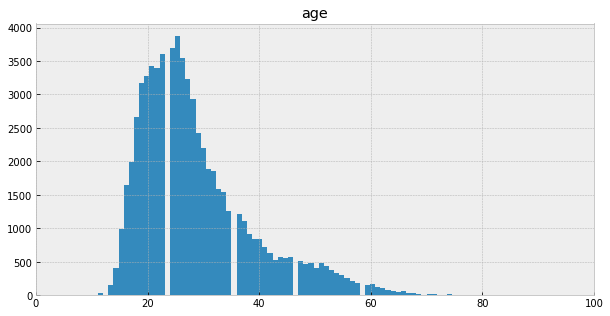

In [59]:
# Age distribution
df_num[['age']].hist(bins=100, figsize=(10,5))
plt.xlim(0, 100)
plt.show()

Most of the people stopped by the police were between 21 and 33.

Next, let's look at the number of people invovled in a field contact.

In [62]:
plc[['num_of_stopped_people']].describe()

,num_of_stopped_people
count,44085.000000
mean,1.598730
std,1.262875
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,30.000000


Most of the field contacts involved 1 - 2 people. 

#### Categorical data

More than 88% of the people are male. 

In [349]:
df.sex.value_counts(dropna=False, normalize=True)

male                          0.888905
female                        0.104668
NaN                           0.005065
unknown                       0.000653
transgender male to female    0.000539
transgender female to male    0.000170
Name: sex, dtype: float64

Almost 70% of the people are Black. However, according to the [US census bureau](https://www.census.gov/quickfacts/bostoncitymassachusetts), whites in Boston outnumber blacks 2:1. 

In [350]:
df.race.value_counts(dropna=False, normalize=True)

black                                       0.687599
white                                       0.244821
unknown                                     0.053916
asian                                       0.006427
NaN                                         0.005690
native american / alaskan native            0.000610
native hawaiian / other pacific islander    0.000553
other                                       0.000383
Name: race, dtype: float64

Let's look at the stop duration and see if some people were stopped for a longer period.

In [351]:
df.stop_duration.value_counts(dropna=False, normalize=True)

five to ten minutes              0.351915
NaN                              0.179696
ten to fifteen minutes           0.157789
less than five minutes           0.120006
fifteen to twenty minutes        0.096964
twenty-five to thirty minutes    0.023680
thirty to forty-five minutes     0.022432
twenty to twenty-five minutes    0.019608
forty-five to sixty minutes      0.011024
one to two hours                 0.010145
longer than two hours            0.006740
Name: stop_duration, dtype: float64

35% of the people were stopped for 5 - 10 minutes.

In [64]:
sd_list = []
for i in list(range(len(df))):
    
    sd = df.iloc[i].stop_duration
    if (sd in ["less than five minutes", "five to ten minute", 
               "ten to fifteen minutes", "fifteen to twenty minutes",
              "twenty to twenty-five minutes", "twenty-five to thirty minutes"]):
        newsd = "less than 30 minutes"
    elif (pd.isnull(sd)):
        newsd = np.nan
    elif (sd in ["forty-five to sixty minutes", "thirty to forty-five minutes"]):
        newsd = "30 minutes to 1 hour"
    else:
        newsd = "longer than 1 hour"
    sd_list.append(newsd)
df["stop_duration_reassigned"] = sd_list

In [68]:
pd.crosstab(df.race, df.stop_duration_reassigned).apply(lambda r: r/r.sum(), axis=1)

stop_duration_reassigned,30 minutes to 1 hour,less than 30 minutes,longer than 1 hour
race,,,
asian,0.037221,0.506203,0.456576
black,0.043160,0.519498,0.437341
native american / alaskan native,0.054054,0.513514,0.432432
native hawaiian / other pacific islander,0.027778,0.638889,0.333333
other,0.181818,0.636364,0.181818
unknown,0.051806,0.512587,0.435607
white,0.032361,0.482018,0.485621


51% of the black people were stopped for less than 30 minutes while 44% of them were stopped for more than 1 hour. 48% of the white people were stopped for less than 30 minutes while 48.5% of them were stopped for more than hour.

#### Frisked or not?

In [73]:
plc.person_involved_in_frisked_or_searched.value_counts(normalize=True, dropna=False)
# need to check whether some values means no frisk conduct was involved

NaN    0.844437
y      0.133288
n      0.022275
Name: person_involved_in_frisked_or_searched, dtype: float64

If we include the Nan values in the dataset, 13% of the field contacts involved at least one person being frisked/searched.

In [74]:
plc.person_involved_in_frisked_or_searched.value_counts(normalize=True)

y    0.85681
n    0.14319
Name: person_involved_in_frisked_or_searched, dtype: float64

If we only look at records with a y/n value, 86% of field contacts involved at least one person being frisked/searched.

#### Will field contacts involved at least one black person have higher frisked/search rate?

In [76]:
b_indvsl_involved = indvsl.groupby("fc_num").apply(
    lambda x: "y"
    if (x.race == "black").any()
    else "n"
    )
plc["black_people_invovled"] = plc[
    "fc_num"
].apply(lambda x: b_indvsl_involved[x])

Let's look at records with an y/n value in the "person_involved_in_frisked_or_searched" column.

In [77]:
frisked_val = plc[plc["person_involved_in_frisked_or_searched"].notna()]

In [80]:
pd.crosstab(frisked_val.person_involved_in_frisked_or_searched, frisked_val.black_people_invovled).apply(lambda r: r/r.sum(), axis=0)

black_people_invovled,n,y
person_involved_in_frisked_or_searched,,
n,0.159256,0.135582
y,0.840744,0.864418


For field contacts that have no black people involved, 84% involved a frisk/search conduct. For field contacts that have at least one black person involved, 86% involved a frisk/search conduct.

#### Next: zip code

#### Next: contact reasons

In [81]:
plc.contact_reason

0        interaction (massachusetts ave/albany street) ...
1        at about 0059 on january 1, 2019 office harlow...
2        r/c for a&b at xxx mass ave. victim xxx (xx/xx...
3        01/01/19 - xxx (inactive brunswick st) was pla...
4        encountered xxx in front of station. matches d...
                               ...                        
44080    traffic stop\nwith xxx xx/xx/xxxx and xxx xx/x...
44081                                                  NaN
44082    xxx and xxx was present during a drug transact...
44083    matched description of 911 call for suspect st...
44084                         warrant arrest: warrant #xxx
Name: contact_reason, Length: 44085, dtype: object